In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install tf_explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.7 MB/s eta 0:00:00


In [3]:
import cv2
import os
import glob
from tqdm import tqdm
import numpy as np
#np.random.seed = 42
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM
from sklearn.model_selection import train_test_split
import pandas as pd

In [4]:
root_dir = '/content/drive/MyDrive/input/Dataset_BUSI_with_GT'
os.listdir(root_dir)

['.DS_Store', 'malignant', 'normal', 'benign']

In [5]:
IMG_WIDTH = 128
IMG_HIGH = 128
IMG_CHANNELS = 3 # number of input channels

In [6]:
def LoadData(root_dir, FolderName, img_width=IMG_WIDTH, img_high=IMG_HIGH, img_channels=IMG_CHANNELS):
  num_samples = 0
  for address in glob.glob(root_dir + f'/{FolderName}/*'):
    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')
    if len(s_address) == 1:
      num_samples += 1

  X = np.zeros((num_samples, img_high, img_width, img_channels), dtype=np.uint8)
  Y = np.zeros((num_samples, img_high, img_width, 1), dtype=np.uint8)


  for address in tqdm(glob.glob(root_dir + f'/{FolderName}/*')):
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(img, (img_width, img_high), interpolation=cv2.INTER_CUBIC)

    s_address = address.split()[-1]
    s_address = s_address.split('.')[0]
    s_address = s_address.split('_')

    idx = s_address[0]
    idx = int(idx.split('(')[1].split(')')[0]) - 1

    if len(s_address) == 1:
      X[idx] = resized_image
      
    elif len(s_address) > 1:
      mask = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
      
      mask = np.expand_dims(mask, axis=-1)
      Y[idx] = np.maximum(mask, Y[idx])

  return X, Y

In [7]:
x_benign, y_benign = LoadData(root_dir, 'benign')
x_malignant, y_malignant = LoadData(root_dir, 'malignant')
x_normal, y_normal = LoadData(root_dir, 'normal')

100%|██████████| 266/266 [00:04<00:00, 62.12it/s] 


In [8]:
X = np.concatenate((x_benign, x_malignant, x_normal), axis=0)
y = np.concatenate((y_benign, y_malignant, y_normal), axis=0)

In [9]:
X_norm = X / 255
y_norm = y / 255

In [10]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_norm,
                                 y_norm, 
                                 test_size=0.1,
                                 random_state=11,
                                 #stratify=y_norm
                                 )
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                            y_train_val,
                            test_size=0.1,
                            random_state=11,
                            #stratify=y_train_val
                            )

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((635, 128, 128, 3),
 (635, 128, 128, 1),
 (71, 128, 128, 3),
 (71, 128, 128, 1),
 (79, 128, 128, 3),
 (79, 128, 128, 1))

In [ ]:
# RGB transform Gray
X_train = tf.image.rgb_to_grayscale(X_train)
X_test = tf.image.rgb_to_grayscale(X_test)
X_val = tf.image.rgb_to_grayscale(X_val)
type(X_train)
#Out[85]: tensorflow.python.framework.ops.EagerTensor
print(X_train.shape, X_test.shape, X_val.shape)
#(439, 224, 224, 1) (236, 224, 224, 1) (110, 224, 224, 1)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
type(X_train)
#Out[87]: numpy.ndarray

In [19]:
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Conv2D, UpSampling2D, Input, add, concatenate, Dropout, Activation, BatchNormalization
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

In [20]:
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    else:
        x= Activation("relu")(x)
    return x

In [21]:
def ResUnet2D(filters, input_hight, input_width):
  #encoder
  inputs = Input(shape=(input_hight, input_width, 1))

  conv = Conv2D(filters*1, kernel_size=(3,3), padding='same', strides=(1,1))(inputs)
  conv = batch_Norm_Activation(conv)
  conv = Conv2D(filters*1, kernel_size=(3,3), padding='same', strides=(1,1))(conv)
  shortcut = Conv2D(filters*1, kernel_size=(3,3), padding='same', strides=(1,1))(inputs) #1_layer residual_block
  shortcut = batch_Norm_Activation(shortcut)
  output1 = add([conv, shortcut]) #1_layer residual_block_add

  res1 = batch_Norm_Activation(output1)
  res1 = Conv2D(filters*2, kernel_size=(3,3), padding='same', strides=(2,2))(res1)
  res1 = batch_Norm_Activation(res1)
  res1 = Conv2D(filters*2, kernel_size=(3,3), padding='same', strides=(1,1))(res1)
  shortcut1 = Conv2D(filters*2, kernel_size=(3,3), padding='same', strides=(2,2))(output1) #2_layer residual_block
  shortcut1 = batch_Norm_Activation(shortcut1)
  output2 = add([shortcut1, res1]) #2_layer residual_block_add

  res2 = batch_Norm_Activation(output2)
  res2 = Conv2D(filters*4, kernel_size=(3,3), padding='same', strides=(2,2))(res2)
  res2 = batch_Norm_Activation(res2)
  res2 = Conv2D(filters*4, kernel_size=(3,3), padding='same', strides=(1,1))(res2)
  shortcut2 = Conv2D(filters*4, kernel_size=(3,3), padding='same', strides=(2,2))(output2)
  shortcut2 = batch_Norm_Activation(shortcut2)
  output3 = add([shortcut2, res2])

  res3 = batch_Norm_Activation(output3)
  res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (2,2))(res3)
  res3 = batch_Norm_Activation(res3)
  res3 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides= (1,1))(res3)
  shortcut3 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(2,2))(output3)
  shortcut3 = batch_Norm_Activation(shortcut3)
  output4 = add([shortcut3, res3])

  res4 = batch_Norm_Activation(output4)
  res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (2,2))(res4)
  res4 = batch_Norm_Activation(res4)
  res4 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(res4)
  shortcut4 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(2,2))(output4)
  shortcut4 = batch_Norm_Activation(shortcut4)
  output5 = add([shortcut4, res4])

  #bridge
  conv = batch_Norm_Activation(output5)
  conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)
  conv = batch_Norm_Activation(conv)
  conv = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides= (1,1))(conv)

  #decoder
  uconv1 = UpSampling2D((2,2))(conv)
  uconv1 = concatenate([uconv1, output4])

  uconv11 = batch_Norm_Activation(uconv1)
  uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
  uconv11 = batch_Norm_Activation(uconv11)
  uconv11 = Conv2D(filters*16, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv11)
  shortcut5 = Conv2D(filters*16, kernel_size= (3,3), padding='same', strides=(1,1))(uconv1)
  shortcut5 = batch_Norm_Activation(shortcut5)
  output6 = add([uconv11,shortcut5])

  uconv2 = UpSampling2D((2,2))(output6)
  uconv2 = concatenate([uconv2, output3])

  uconv22 = batch_Norm_Activation(uconv2)
  uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
  uconv22 = batch_Norm_Activation(uconv22)
  uconv22 = Conv2D(filters*8, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv22)
  shortcut6 = Conv2D(filters*8, kernel_size= (3,3), padding='same', strides=(1,1))(uconv2)
  shortcut6 = batch_Norm_Activation(shortcut6)
  output7 = add([uconv22,shortcut6])

  uconv3 = UpSampling2D((2,2))(output7)
  uconv3 = concatenate([uconv3, output2])

  uconv33 = batch_Norm_Activation(uconv3)
  uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
  uconv33 = batch_Norm_Activation(uconv33)
  uconv33 = Conv2D(filters*4, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv33)
  shortcut7 = Conv2D(filters*4, kernel_size= (3,3), padding='same', strides=(1,1))(uconv3)
  shortcut7 = batch_Norm_Activation(shortcut7)
  output8 = add([uconv33,shortcut7])

  uconv4 = UpSampling2D((2,2))(output8)
  uconv4 = concatenate([uconv4, output1])

  uconv44 = batch_Norm_Activation(uconv4)
  uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
  uconv44 = batch_Norm_Activation(uconv44)
  uconv44 = Conv2D(filters*2, kernel_size= (3,3), padding= 'same', strides=(1,1))(uconv44)
  shortcut8 = Conv2D(filters*2, kernel_size= (3,3), padding='same', strides=(1,1))(uconv4)
  shortcut8 = batch_Norm_Activation(shortcut8)
  output9 = add([uconv44,shortcut8])

  output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(output9)
  model = Model(inputs, output_layer)

  return model

In [22]:
model = ResUnet2D(64, 128, 128)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 activation_56 (Activation)     (None, 128, 128, 64  0           ['conv2d_60[0][0]']              
                                )                                                           

In [23]:
def dice_coef(y_test, y_pred):
  smooth = 1
  y_test_f = K.flatten(y_test)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_test_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_test_f * y_test_f) + K.sum(y_pred_f * y_pred_f) + smooth)

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0003), loss='binary_crossentropy', metrics=[dice_coef])

In [25]:
results = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50)

Epoch 1/50
40/40 [==============================] - 78s 1s/step - loss: 0.3460 - dice_coef: 0.1881 - val_loss: 0.2462 - val_dice_coef: 0.2800
Epoch 2/50
40/40 [==============================] - 31s 770ms/step - loss: 0.2026 - dice_coef: 0.3510 - val_loss: 0.2373 - val_dice_coef: 0.2442
Epoch 3/50
40/40 [==============================] - 30s 762ms/step - loss: 0.1926 - dice_coef: 0.3685 - val_loss: 0.2144 - val_dice_coef: 0.3576
Epoch 4/50
40/40 [==============================] - 31s 776ms/step - loss: 0.1771 - dice_coef: 0.4520 - val_loss: 0.2225 - val_dice_coef: 0.4441
Epoch 5/50
40/40 [==============================] - 31s 772ms/step - loss: 0.1721 - dice_coef: 0.5086 - val_loss: 0.1814 - val_dice_coef: 0.5547
Epoch 6/50
40/40 [==============================] - 31s 778ms/step - loss: 0.1507 - dice_coef: 0.5923 - val_loss: 0.1813 - val_dice_coef: 0.5978
Epoch 7/50
40/40 [==============================] - 31s 770ms/step - loss: 0.1464 - dice_coef: 0.6180 - val_loss: 0.1532 - val_dice_c

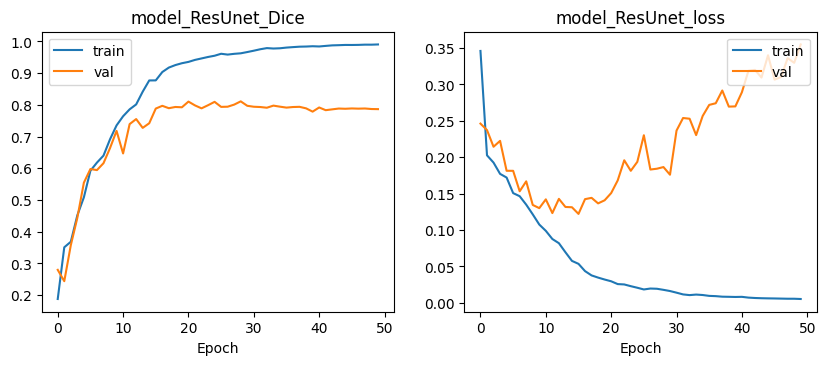

In [26]:
#model_unet
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('model_ResUnet_Dice')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model_ResUnet_loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')

In [27]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ', score[0])
print('Test dice', score[1])

3/3 [==============================] - 20s 4s/step - loss: 0.4794 - dice_coef: 0.7687
Test loss:  0.47936132550239563
Test dice 0.7687268853187561


3/3 [==============================] - 1s 456ms/step


Text(0.5, 1.0, 'image')

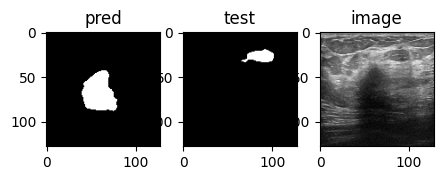

In [28]:
pred = model.predict(X_test)
pred[pred>=0.5]=1
pred[pred<=0.5]=0

i=8
plt.figure(figsize=(5, 8))
plt.subplot(1, 3, 1)
plt.imshow(pred[i], cmap='gray')
plt.title("pred")
plt.subplot(1, 3, 2)
plt.imshow(y_test[i], cmap='gray')
plt.title("test")
plt.subplot(1, 3, 3)
plt.imshow(X_test[i], cmap='gray')
plt.title("image")


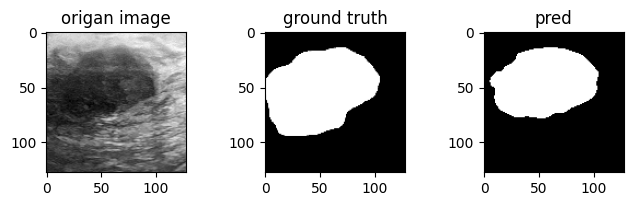

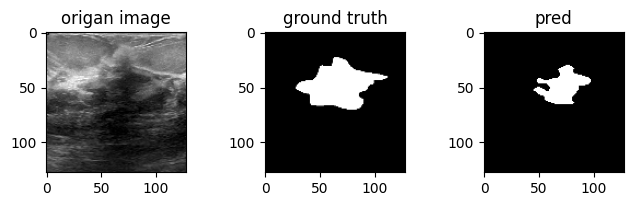

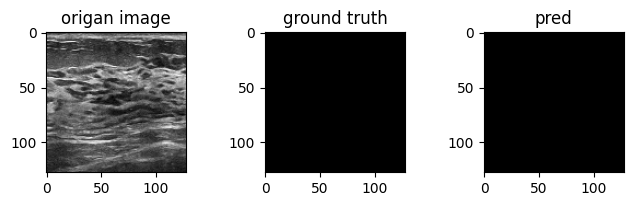

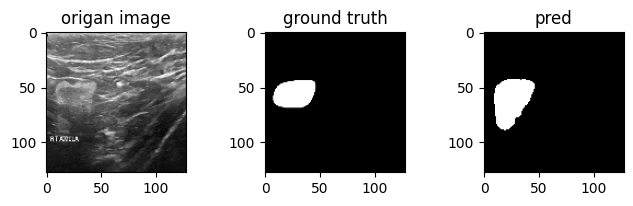

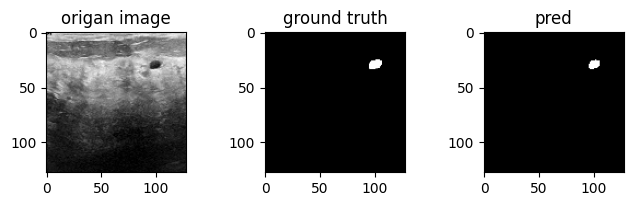

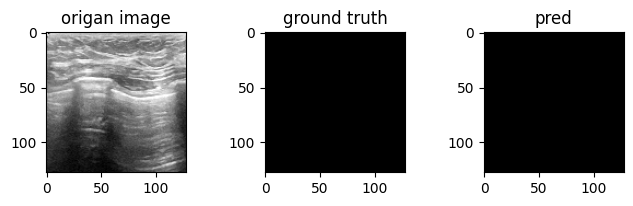

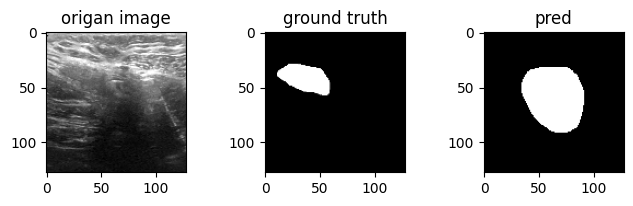

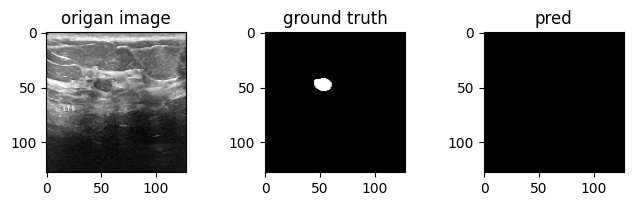

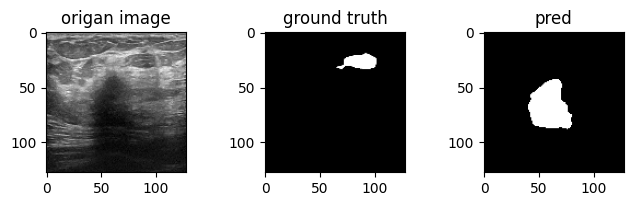

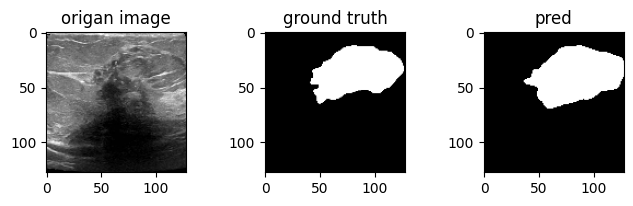

In [30]:
for i in range(10):
  plt.figure(figsize=(8, 4))
  plt.subplot(2, 3, 1)
  plt.title("origan image")
  plt.imshow(X_test[i], cmap='gray')
  plt.subplot(2, 3, 2)
  plt.title("ground truth")
  plt.imshow(y_test[i], cmap='gray')
  plt.subplot(2, 3, 3)
  plt.title("pred")
  plt.imshow(pred[i], cmap='gray')
  plt.show()